# Import

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.26.1 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import itertools
import time
import warnings
from collections import Counter
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import tensorflowjs as tfjs
import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings('ignore')

2025-05-19 02:21:33.959137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747621294.188375      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747621294.259691      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load dan Tranformasi

In [3]:
IMG_SIZE = (255, 255)
BATCH_SIZE = 32

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def normalize_image(img):
    img = tf.cast(img, tf.float32) / 255.0
    img = (img - IMAGENET_MEAN) / IMAGENET_STD
    return img

def random_rotate(image):
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    return tf.image.rot90(image, k)

def preprocess_train(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = random_rotate(image) 
    image = normalize_image(image)
    return image, label

def preprocess_eval(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = normalize_image(image)
    return image, label



In [4]:
for dirname, _, _ in os.walk("/kaggle/input"):
    print(dirname)

/kaggle/input
/kaggle/input/diagnosis-of-diabetic-retinopathy
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/valid
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/valid/DR
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/valid/No_DR
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/test
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/test/DR
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/test/No_DR
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/train
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/train/DR
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/train/No_DR
/kaggle/input/diagnosis-of-diabetic-reti

In [5]:
data_dir = "/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy"

train_set = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
).map(preprocess_train).shuffle(1000).prefetch(tf.data.AUTOTUNE)

val_set = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/valid",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
).map(preprocess_eval).prefetch(tf.data.AUTOTUNE)

test_set = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
).map(preprocess_eval).prefetch(tf.data.AUTOTUNE)

Found 2076 files belonging to 2 classes.


I0000 00:00:1747621318.232981      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747621318.233738      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 531 files belonging to 2 classes.
Found 231 files belonging to 2 classes.


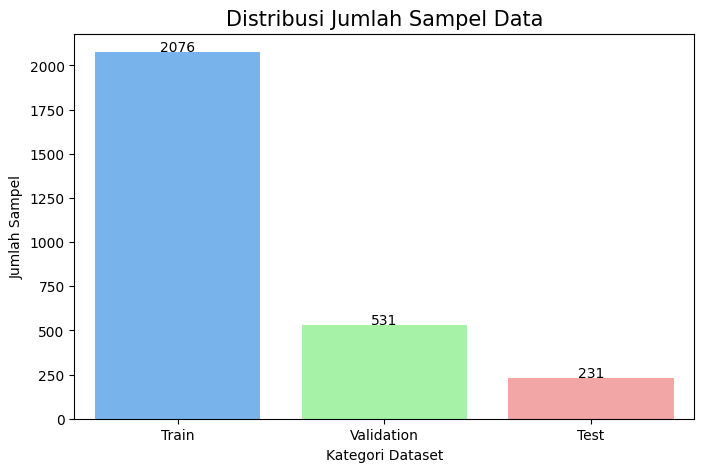

In [6]:
def total_samples(dataset):
    total = 0
    for images, labels in dataset:
        total += images.shape[0]
    return total
categories = ['Train', 'Validation', 'Test']
colors = ['#66b3ff', '#99ff99', '#ff9999']
counts_samples = [total_samples(train_set), total_samples(val_set), total_samples(test_set)]

plt.figure(figsize=(8, 5))
sns.barplot(x=categories, y=counts_samples, palette=colors)
plt.title('Distribusi Jumlah Sampel Data', fontsize=15)
plt.xlabel('Kategori Dataset')
plt.ylabel('Jumlah Sampel')
for i, count in enumerate(counts_samples):
    plt.text(i, count + 5, str(count), ha='center')
plt.show()


Found 2076 files belonging to 2 classes.


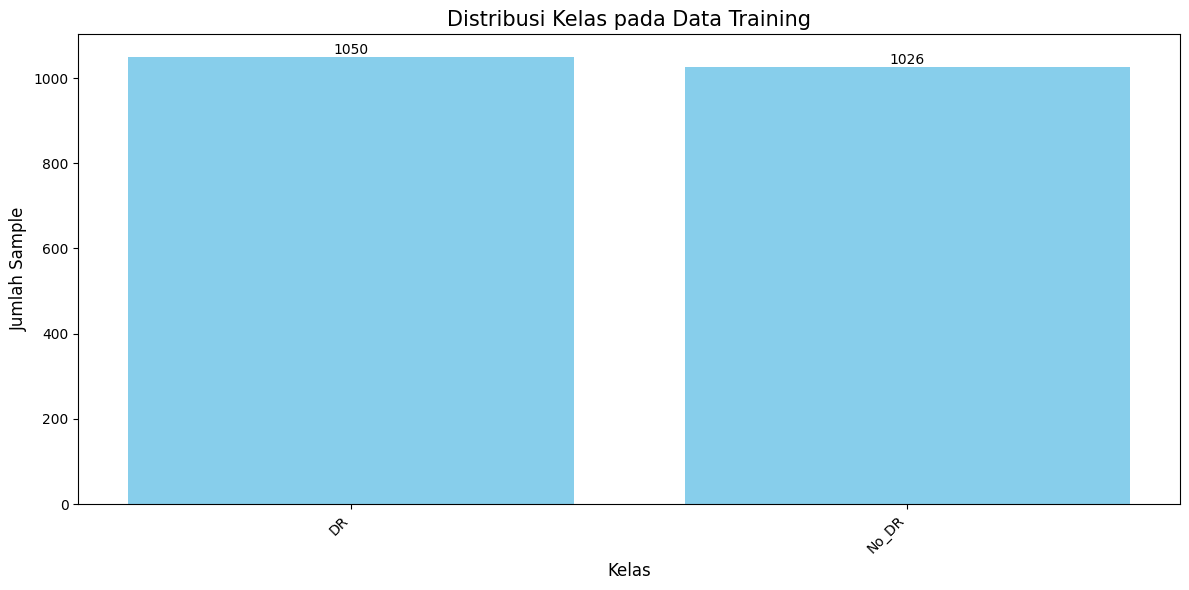

In [7]:
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)
class_names = raw_train_ds.class_names

all_labels = []
for _, labels in raw_train_ds.unbatch():
    all_labels.append(int(labels.numpy()))

class_counts = Counter(all_labels)

class_names_sorted = [class_names[i] for i in sorted(class_counts.keys())]
counts = [class_counts[i] for i in sorted(class_counts.keys())]

plt.figure(figsize=(12, 6))
bars = plt.bar(class_names_sorted, counts, color='skyblue')

plt.title('Distribusi Kelas pada Data Training', fontsize=15)
plt.xlabel('Kelas', fontsize=12)
plt.ylabel('Jumlah Sample', fontsize=12)
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

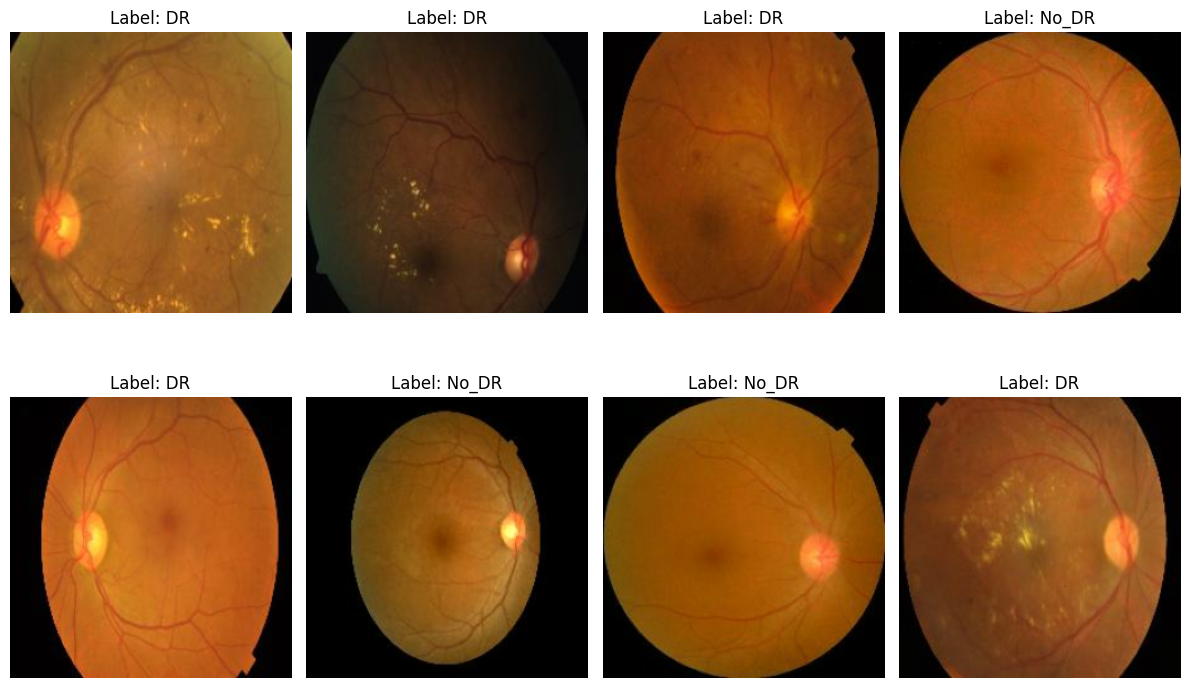

In [8]:
def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    return np.clip(img, 0, 1)

plt.figure(figsize=(12, 8))

for images, labels in train_set.take(1):
    images = images.numpy()
    labels = labels.numpy()

    for i in range(8):
        img = denormalize(images[i])
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis('off')

plt.tight_layout()
plt.show()

# Build Model RestNet50 + CNN

In [9]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(255, 255, 3))
base_model.trainable = True  

for layer in base_model.layers[:-30]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 14,975,234 (57.13 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

In [10]:
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)

In [11]:
history = model.fit(
    train_set,               
    validation_data=val_set, 
    epochs=30,               
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30


I0000 00:00:1747621377.369813      73 service.cc:148] XLA service 0x7f4258016f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747621377.370891      73 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747621377.370911      73 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747621379.216267      73 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/65 ━━━━━━━━━━━━━━━━━━━━ 40:38 38s/step - accuracy: 0.4062 - loss: 0.8756

I0000 00:00:1747621388.142410      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


65/65 ━━━━━━━━━━━━━━━━━━━━ 67s 445ms/step - accuracy: 0.7304 - loss: 0.5322 - val_accuracy: 0.7571 - val_loss: 0.5077 - learning_rate: 1.0000e-05
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - accuracy: 0.8906 - loss: 0.2552 - val_accuracy: 0.8399 - val_loss: 0.3800 - learning_rate: 1.0000e-05
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - accuracy: 0.9051 - loss: 0.2539 - val_accuracy: 0.9134 - val_loss: 0.2489 - learning_rate: 1.0000e-05
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - accuracy: 0.9249 - loss: 0.2044 - val_accuracy: 0.9153 - val_loss: 0.2251 - learning_rate: 1.0000e-05
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - accuracy: 0.9365 - loss: 0.1896 - val_accuracy: 0.9190 - val_loss: 0.2013 - learning_rate: 1.0000e-05
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.9423 - loss: 0.1639 - val_accuracy: 0.9209 - val_loss: 0.2027 - learning_rate: 1.0000e-05
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 183ms/step - accuracy: 0.92

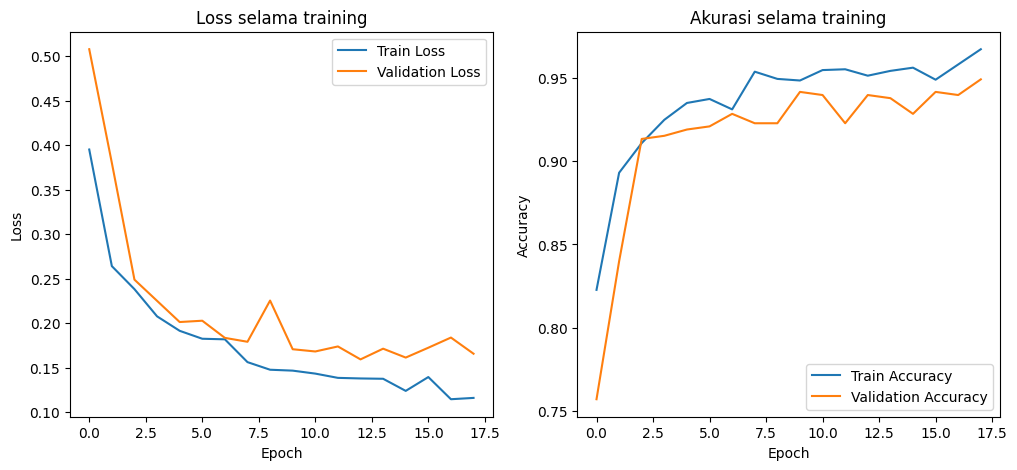

In [12]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss selama training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Akurasi selama training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_history(history)

In [13]:
y_true = []
y_pred = []

for images, labels in val_set:   
    preds = model.predict(images)
    preds_labels = preds.argmax(axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds_labels)

print(classification_report(y_true, y_pred))

f1 = f1_score(y_true, y_pred, average='macro')
print(f"F1-score (macro): {f1:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       245
           1       0.93      0.95      0.94       286

    accuracy                           0.94       531
   macro avg       0.94      0.94      0.94       531
weighted avg       0.94      0.94      0.94       531

F1-score (macro): 0.9393


In [14]:
model.save("Model_ResnetCNN.h5")


# Build Model Densenet121 + CNN + RCNN

In [15]:
# # Load pretrained DenseNet121 base model (tanpa top)
# base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(255, 255, 3))

# # Freeze base model for initial training
# base_model.trainable = False

# # Tambahkan RCNN-like detection head
# model_2 = models.Sequential([
#     base_model,
#     layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),  # RCNN-like head
#     layers.GlobalAveragePooling2D(),
#     layers.Dropout(0.5),
#     layers.Dense(2, activation='softmax')  # Ganti 2 dengan jumlah kelas
# ])

# # Compile model
# model_2.compile(
#     optimizer='adam',
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# model_2.summary()

In [16]:
# # Jalankan training
# history_2 = model_2.fit(
#     train_set,               # Dataset training
#     validation_data=val_set, # Dataset validasi
#     epochs=30,               # Jumlah epoch training
#     callbacks=[early_stop, reduce_lr]
# )